In [1]:
%matplotlib inline
import numpy as np
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from timeit import default_timer as timer
import time
import pickle
from tqdm import tqdm
import pandas as pd
import nltk
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
class SimpleTimer:
    def __init__(self):
        self.start = None
        self.end = None
        self.elapsed = None

    def __enter__(self):
        self.start = time.perf_counter_ns()
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time.perf_counter_ns()
        self.elapsed = self.end - self.start
        
def visualize_data(path):

    data = pickle.load(open(path, "rb"))
    df_list = [["n_workers", "sample_run", "overall", "data_read", "data_preprocessing", "hashing_vectorizer", "tfidf_transformer", "nrows"]]
    for n_workers in data:
        temp_data = data[n_workers]
        if isinstance(temp_data, float):
            continue
        results = temp_data["sample_run_results"]
        for sample_run in range(len(results)):
            timings = results[sample_run]
            df_list.append([n_workers, sample_run, timings["overall"]/1e9, 
                           timings["data_read"]/1e9, timings["data_preprocessing"]/1e9,timings["hashing_vectorizer"]/1e9, 
                           timings["tfidf_transformer"]/1e9, timings["nrows"]])
    
    perf_df = pd.DataFrame(df_list[1:], columns=df_list[0])
    fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
    dd = pd.melt(perf_df, 
                 id_vars=['n_workers'],
                 value_vars=['overall','data_read', 'data_preprocessing', 'hashing_vectorizer','tfidf_transformer'],
                 var_name='latency')
    sns.boxplot(x='latency',y='value',data=dd, orient="v")
    plt.show()
    return perf_df, dd 

In [3]:
nltk.download('stopwords')
STOPWORDS = nltk.corpus.stopwords.words('english')
PUNCTUATIONS = [ '!', '"', '#', '$', '%', '&', '(', ')', '*', '+', '-', '.', '/',  '\\', ':', ';', '<', '=', '>',
           '?', '@', '[', ']', '^', '_', '`', '{', '|', '}', '\t','\n',"'",",",'~' , '—']

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
def performance_numbers(parquet_path, worker_counts=[1], samples=1, data_frac=0.2, result_path="./results.pkl", 
                        seed=42, model_args={}, model_kwargs={}):
    """
    Main function to perform the performance sweep
    """
    data_frac = min(1.0, data_frac)
    overall_perf_result = {"data_fraction": data_frac}
    
    for n in worker_counts: 
        overall_perf_result[n]={"sample_run_results": []}
        
        for i in tqdm(range(samples)): 
            sample_record = {"overall":0, "data_read":0, "hashing_vectorizer":0, "tfid_transformer":0, "data_preprocessing":0, "nrows":0}
            with SimpleTimer() as overalltimer:
                with SimpleTimer() as timer:
                    data = pd.read_parquet(parquet_path).sample(frac=data_frac, random_state=seed)
                sample_record["data_read"]=timer.elapsed
                print(f"Workers:{n}, Sample Run:{i}, Finished loading data in {timer.elapsed}s")
                
                with SimpleTimer() as timer:
                    data = data[data['review_body'].notna()]
                    # from https://stackoverflow.com/questions/50444346/fast-punctuation-removal-with-pandas
                    transtable = str.maketrans(dict.fromkeys("".join(PUNCTUATIONS), ''))
                    data['review_body'] = (data['review_body'].str.lower()
                                           .str.translate(transtable)
                                           .str.strip())
                    data['review_body'] = data['review_body'].apply(lambda x: ' '.join([word for word in x.split() if word not in STOPWORDS]))                    
                sample_record["data_preprocessing"]=timer.elapsed
                print(f"Workers:{n}, Sample Run:{i}, Finished preprocessing data in {timer.elapsed}s")
                
                with SimpleTimer() as timer:
                    vectorizer = HashingVectorizer(stop_words='english', preprocessor=None)
                    # Meta is an empty dataframe matches the dtypes and columns of the output
                    hashed_count_vector = vectorizer.fit_transform(data["review_body"])
                sample_record["hashing_vectorizer"]=timer.elapsed
                print(f"Workers:{n}, Sample Run:{i}, Finished fitting HashVectorizer in {timer.elapsed}s")
                
                with SimpleTimer() as timer:
                    transformer = TfidfTransformer()
                    # Meta is an empty dataframe matches the dtypes and columns of the output
                    X_transformed = vectorizer.fit_transform(data["review_body"])
                sample_record["tfidf_transformer"]=timer.elapsed
                print(f"Workers:{n}, Sample Run:{i}, Finished fitting TfIDTransformer in {timer.elapsed}s")
                
            sample_record["overall"]=overalltimer.elapsed
            sample_record["nrows"]=data.shape[0]
            print(f"Workers:{n}, Sample Run:{i}, Finished transforming using TFIDFTransformer in {overalltimer.elapsed}s")
            overall_perf_result[n]["sample_run_results"].append(sample_record)
    
    with open(result_path, "wb") as file:
        pickle.dump(overall_perf_result, file)
    

In [5]:
dataset = "PC"
parquet_path = f'./data/product_category={dataset}'
model_kwargs = {"text_preprocessor":text_preprocessor}
samples = 2
worker_counts = [1]
result_path = f"./results/result_poc_nlp_sklearn_{dataset}.pkl"

In [6]:
%%time
performance_numbers(parquet_path=parquet_path, worker_counts=worker_counts, samples=samples, data_frac=1, result_path=result_path, 
                        seed=42, model_args={}, model_kwargs=model_kwargs)

  0%|          | 0/2 [00:00<?, ?it/s]

Workers:1, Sample Run:0, Finished loading data in 28855931317s
Workers:1, Sample Run:0, Finished preprocessing data in 915214701007s
Workers:1, Sample Run:0, Finished fitting HashVectorizer in 229313526172s


 50%|█████     | 1/2 [23:22<23:22, 1402.37s/it]

Workers:1, Sample Run:0, Finished fitting TfIDTransformer in 228985160575s
Workers:1, Sample Run:0, Finished transforming using TFIDFTransformer in 1402370560300s
Workers:1, Sample Run:1, Finished loading data in 30258611978s
Workers:1, Sample Run:1, Finished preprocessing data in 915128577353s
Workers:1, Sample Run:1, Finished fitting HashVectorizer in 227142814261s


100%|██████████| 2/2 [46:42<00:00, 1401.31s/it]

Workers:1, Sample Run:1, Finished fitting TfIDTransformer in 227721500006s
Workers:1, Sample Run:1, Finished transforming using TFIDFTransformer in 1400252504572s
CPU times: user 46min 14s, sys: 1min 1s, total: 47min 16s
Wall time: 46min 42s


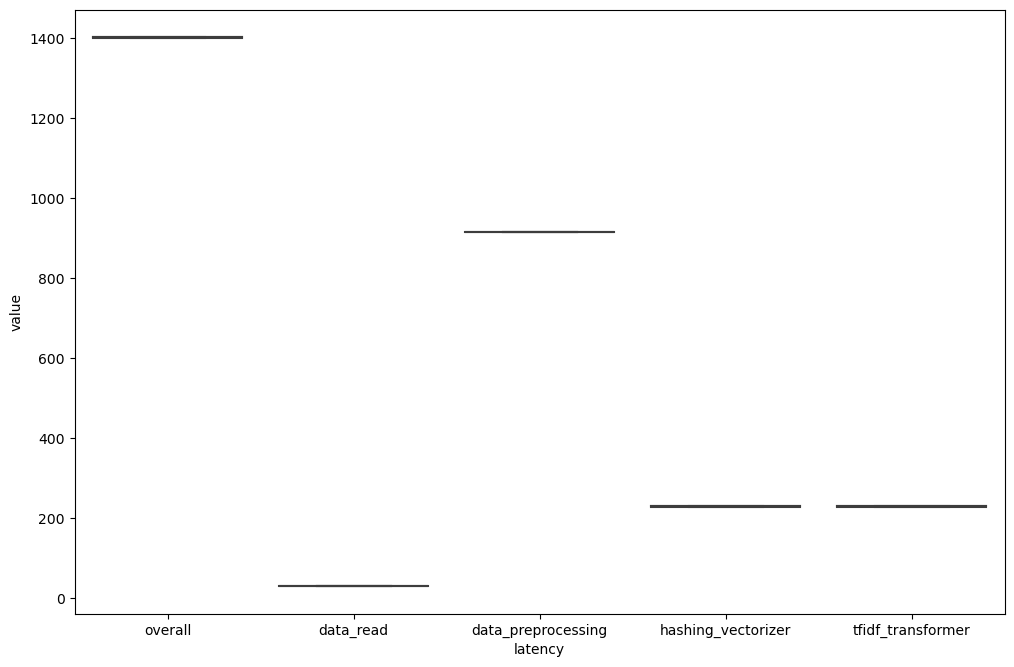

In [7]:
data, melt_data = visualize_data(result_path)    

In [8]:
data

,n_workers,sample_run,overall,data_read,data_preprocessing,hashing_vectorizer,tfidf_transformer,nrows
0,1,0,1402.370560,28.855931,915.214701,229.313526,228.985161,7004147
1,1,1,1400.252505,30.258612,915.128577,227.142814,227.721500,7004147


In [9]:
groupy = data.groupby("n_workers").agg(['mean', 'std', 'count'])

In [10]:
groupy

sample_run                      overall                  data_read  \
                mean       std count         mean       std count       mean   
n_workers                                                                      
1                0.5  0.707107     2  1401.311532  1.497692     2  29.557272   

                          data_preprocessing  ...       hashing_vectorizer  \
                std count               mean  ... count               mean   
n_workers                                     ...                            
1          0.991845     2         915.171639  ...     2          228.22817   

                          tfidf_transformer                    nrows       \
                std count              mean       std count     mean  std   
n_workers                                                                   
1          1.534925     2         228.35333  0.893543     2  7004147  0.0   

                 
          count  
n_workers        
1             2  

[1 rows x 21 columns]